### import modules

In [1]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['ordinance','tagum','city','thereof','municipal','municipality', 'section', 'penalties', 'ord','mun'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii'])

### Import Tagum dataset

In [3]:
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


Add ordinance descriptions to a list

In [4]:
data = list(df.OT) 
print(data[:1]) # preview

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [5]:
import re
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]

Tokenize and preprocess text

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang']]


In [7]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2)]]


In [8]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('attended', 1),
  ('birth', 2),
  ('deliveries', 1),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [9]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,workers=3,
                                           num_topics=15, 
                                           random_state=123,
                                           
                                           chunksize=100,
                                           passes=30,
                                          
                                           per_word_topics=True)

In [10]:
doc_lda = lda_model[corpus]

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

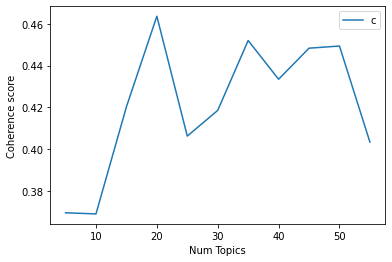

Num Topics = 5  has Coherence Value of 0.3696
Num Topics = 10  has Coherence Value of 0.3691
Num Topics = 15  has Coherence Value of 0.4203
Num Topics = 20  has Coherence Value of 0.4636
Num Topics = 25  has Coherence Value of 0.4063
Num Topics = 30  has Coherence Value of 0.4186
Num Topics = 35  has Coherence Value of 0.452
Num Topics = 40  has Coherence Value of 0.4334
Num Topics = 45  has Coherence Value of 0.4483
Num Topics = 50  has Coherence Value of 0.4493
Num Topics = 55  has Coherence Value of 0.4034


In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

K = 15 is the optimal number of topics since when

In [13]:
optimal_model = model_list[2] # when number of topics is 15
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"davao" + 0.026*"operation" + 0.022*"program" + 0.022*"norte" + '
  '0.022*"del" + 0.021*"guidelines" + 0.020*"public" + 0.018*"regulations" + '
  '0.017*"implementation" + 0.017*"establishment"'),
 (1,
  '0.036*"purposes" + 0.023*"within" + 0.022*"violations" + 0.021*"meters" + '
  '0.021*"tct" + 0.021*"square" + 0.020*"area" + 0.018*"barangay" + '
  '0.015*"lot" + 0.014*"private"'),
 (2,
  '0.024*"service" + 0.023*"pesos" + 0.023*"oaths" + 0.021*"year" + '
  '0.017*"issuance" + 0.015*"ten" + 0.015*"school" + 0.014*"fee" + '
  '0.013*"office" + 0.013*"authorized"'),
 (3,
  '0.046*"public" + 0.040*"street" + 0.031*"vehicles" + 0.023*"utility" + '
  '0.020*"streets" + 0.019*"market" + 0.019*"portion" + 0.018*"violation" + '
  '0.017*"within" + 0.016*"bonifacio"'),
 (4,
  '0.055*"market" + 0.028*"premises" + 0.020*"stalls" + 0.020*"public" + '
  '0.014*"area" + 0.014*"tables" + 0.014*"vendors" + 0.012*"per" + '
  '0.012*"provided" + 0.010*"construction"'),
 (5,
  '0.041*"fu

In [14]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9222,"tax, code, known, otherwise, two, article, rev...",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME...
1,1,11.0,0.9678,"tricycle, pesos, hire, fees, health, act, moto...",“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE...
2,2,5.0,0.5808,"funds, position, office, purpose, duties, nece...",“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FO...
3,3,2.0,0.6179,"service, pesos, oaths, year, issuance, ten, sc...","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 A..."
4,4,9.0,0.4135,"series, fee, enacted, december, davao, every, ...","“AN ORDINANCE THE CITY HISTORICAL, CULTURAL AN..."
5,5,10.0,0.8963,"funds, barangay, guidelines, council, developm...",“AN ORDINANCE THE HUGPONG SERBISYO PARA SA TAG...
6,6,7.0,0.3657,"tax, code, known, otherwise, two, article, rev...",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORI...
7,7,6.0,0.5515,"violation, public, office, one, license, fees,...",AN ORDINANCE SECTION 2 OF CITY ORDINANCE NO. 2...
8,8,7.0,0.6291,"tax, code, known, otherwise, two, article, rev...",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS...
9,9,3.0,0.5360,"public, street, vehicles, utility, streets, ma...",“AN ORDINANCE TEMPORARY CLOSURE FROM CORNER R...


In [15]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(15)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9689,"davao, operation, program, norte, del, guidelines, public, regulations, implementation, establishment","“AN ORDINANCE LOT NO. (T-2471) T-633 AND LOT NO. 4-E, PSD-11-024525 ALL OWNED BY JOSE S. GARCIA SITUATED IN MANKILAM, TAGUM, DAVAO, THE FORMER BOUNDED ON THE LINES 1-3 BY PROPERTY OF PAULINO CALAMBA; ALONG LINES 3-6, BY PROPERTY OF MARIANO BELLO; ALONG LINE 6-7 BY PROPERTY OF AMBROCIO FERIDO; AND ALONG LINE continue reading : MUNICIPAL ORDINANCE N0. 21, s-1996"
1,1.0,0.9627,"purposes, within, violations, meters, tct, square, area, barangay, lot, private","AN ORDINANCE A PARCEL OF LAND REGISTERED IN THE NAME OF ANGELITA MAGDANGAL MARTINEZ ET. AL. EMBRACED BY TCT NOS. T-172237 AND T-191543, A TOTAL AREA OF 43,777 SQUARE METERS LOCATED AT PUROK MAGKIDONG, BARANGAY MANKILAM, TAGUM CITY FROM AGRICULTURAL TO RESIDENTIAL PURPOSES."
2,2.0,0.9654,"service, pesos, oaths, year, issuance, ten, school, fee, office, authorized","“AN ORDINANCE THE VOLUME OF SOUND AND MUSIC GENERATED FROM INSTALLED JUKE BOXES, MINUS ONE MACHINES, PUBLIC ADDRESS SYSTEM, LIVE BAND AND COMBO MUSIC IN DISCO HOUSES, BEER GARDENS, COCKTAIL LOUNGES, AND OTHER SIMILAR BUSINESS ESTABLISHMENTS”."
3,3.0,0.9699,"public, street, vehicles, utility, streets, market, portion, violation, within, bonifacio",“AN ORDINANCE ILLEGAL OR THE AND OF PASSENGERS / CARGOES/ MERCHANDISES WITHIN A DISTANCE OF SIX (6) METERS FROM THE CORNER/INTERSECTION/JUNCTION OF BONIFACIO-QUEZON; QUEZON-SOBRECAREY; RIZAL-BONIFACIO; ROXAS-BONIFACIO; QUEZON-PIONEER AVENUE; SOBRECAREY-PIONEER AVENUE; PIONEER-NATIONAL HIGHWAY AND STREETS IN THE MUNICIPALITY OF TAGUM AND PENALTIES FOR VIOLATION THEREOF”.
4,4.0,0.9576,"market, premises, stalls, public, area, tables, vendors, per, provided, construction",An ordinance designating the vacant land area adjacent and belonging to the public market as a service parking area declaring all perimeter roads of the market premises as loading and unloading zones only and providing penalties for violation thereof.
5,5.0,0.9733,"funds, position, office, purpose, duties, necessary, ii, legislative, officer, staff","RESOLUTION THE HONORABLE RENE VILLA, LLB, SECRETARY OF THE DEPARTMENT OF AGRARIAN REFORM (DAR) FOR FINANCIAL SUPPORT IN THE AMOUNT OF EIGHTY MILLION (Php 80,000,000.00) PESOS FOR THE CONSTRUCTION/IMPROVEMENT OF 8-KMS FARM-TO-MARKET ROAD (FMR) AT BARANGAY SAN MIGUEL – BARANGAY CANOCOTAN – CIRCUMFERENTIAL ROAD-DAVAO REGIONAL HOSPITAL."
6,6.0,0.9678,"violation, public, office, one, license, fees, four, way, national, property","AN ORDINANCE INCENTIVES AND RELIEF IN THE FORM OF CONDONATION OF REAL PROPERTY TAX AND/OR PENALTIES TO REAL PROPERTY OWNERS OF TAGUM CITY WHOSE PORTION/S OF THEIR PROPERTY/IES HAD BEEN UTILIZED AS ROAD RIGHT OF WAYS, DRAINAGE AND OTHER PUBLIC USE/PURPOSES, SUBJECT TO CERTAIN CONDITIONS HERETO STATED AND FOR OTHER PURPOSES."
7,7.0,0.9627,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay","AN ORDINANCE LOT NOS. 6039, 6035 AND 6036, ALL OF CSD-1378 AN AREA OF 46,992 SQ. M., 39,906 SQ. M., AND 19,303, REGISTERED IN THE NAME OF VICENTE B. DAMOLO, GRACIANO RAMOS AND ALBERTO MAITEM, RESPECTIVELY, SITUATED AT BARANGAY NUEVA FUERZA, TAGUM CITY, FROM AGRICULTURAL TO INSTITUTIONAL ZONE/SANITARY LANDFILL."
8,8.0,0.9654,"video, annual, operation, within, operators, area, license, limit, services, permit","“AN ORDINANCE ALL CONTRACTOR/CONSTRUCTOR NATIONAL FUNDED INFRASTRUCTURE PROJECTS IN THE MUNICIPALITY OF TAGUM TO SUBMIT A COPY OF THE PROGRAM OF WORK ITS DESIGN AND CONTRACT ENTERED INTO BY THE CONTRACTOR/CONSTRUCTOR WITH THE DEPARTMENT OF PUBLIC WORKS AND HIGHWAYS (DPWH) AND ALL OTHER NATIONAL GOVERNMENT AGENCIES TO THE MUNICIPAL MAYOR OF continue reading : MUNICIPAL ORDINANCE NO. 10, s-1991"
9,9.0,0.9667,"series, fee, enacted, december, davao, every, certain, elementary, violations, funds","“ AN ORDINANCE A FINE OR PENALTY TO ANY INDIVIDUAL OR 

In [16]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 7.0]

df_sorted_by_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9222,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.
6,6,7.0,0.3657,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORICAL AND CULTURAL CENTER AS THE RIZAL PARK OF TAGUM CITY”.
8,8,7.0,0.6291,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS OF ARELLANO AND BONIFACIO STREETS FOR THE TRADE FAIR ACTIVITY AS PART OF THE COOP MONTH CELEBRATION 2017 FROM 4:00 IN THE AFTERNOON TILL 11:00 IN THE
20,20,7.0,0.6255,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay","“AN ORDINANCE ARTICLE IV, SECTION 2 OF CITY ORDINANCE NO. 383, SERIES OF 2009 OTHERWISE KNOWN AS THE COMPREHENSIVE WELFARE CODE FOR THE CHILDREN OF THE CITY OF TAGUM, AND FOR OTHER PURPOSES”."
25,25,7.0,0.7507,"tax, code, known, otherwise, two, article, revised, chapter, comprehensive, barangay","AN ORDINANCE SECTION 26 OF CITY ORDINANCE NO. 383, S-2009, OTHERWISE KNOWN AS THE COMPREHENSIVE WELFARE CODE FOR THE CHILDREN OF THE CITY OF TAGUM, AND FOR OTHER PURPOSES."


In [17]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


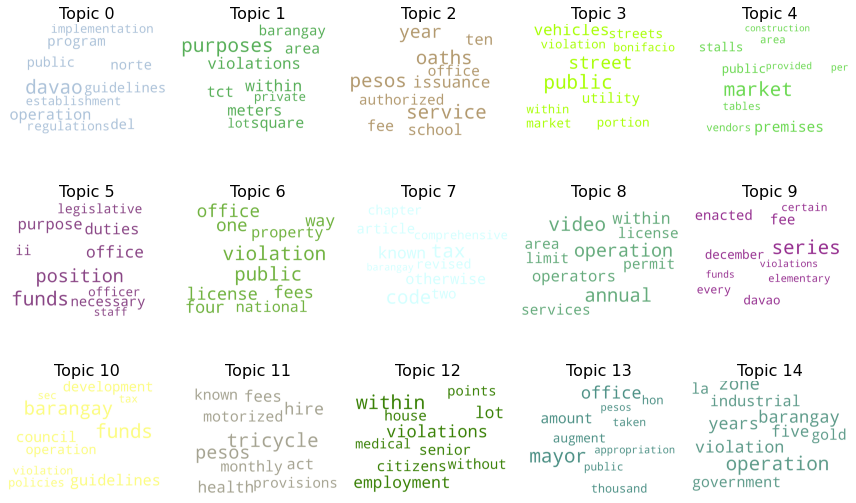

In [18]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=15,formatted=False)

fig, axes = plt.subplots(3, 5, figsize=(12,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

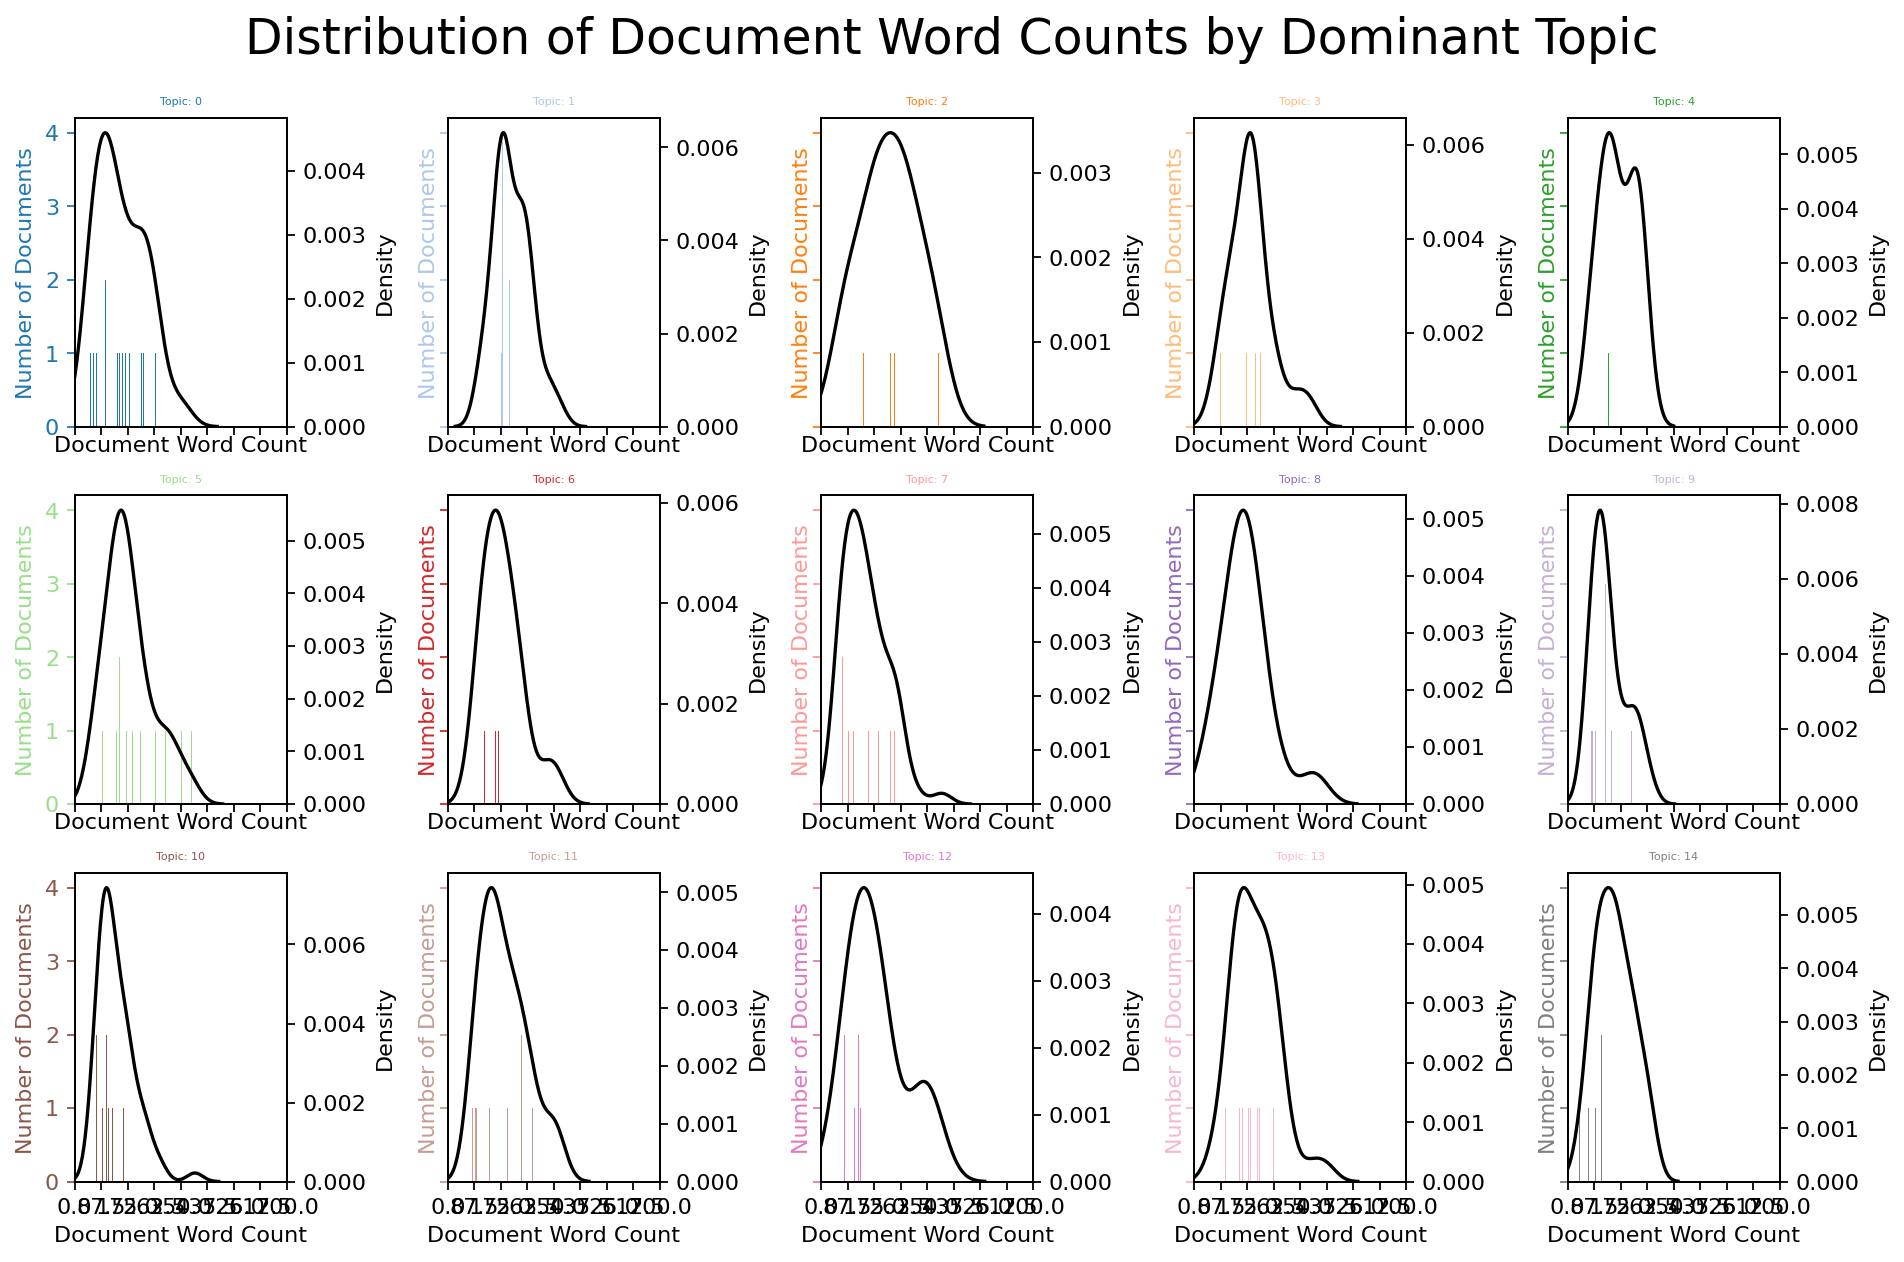

In [19]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 700, color=tableau20[i])
    ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 700), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=tableau20[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,700,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

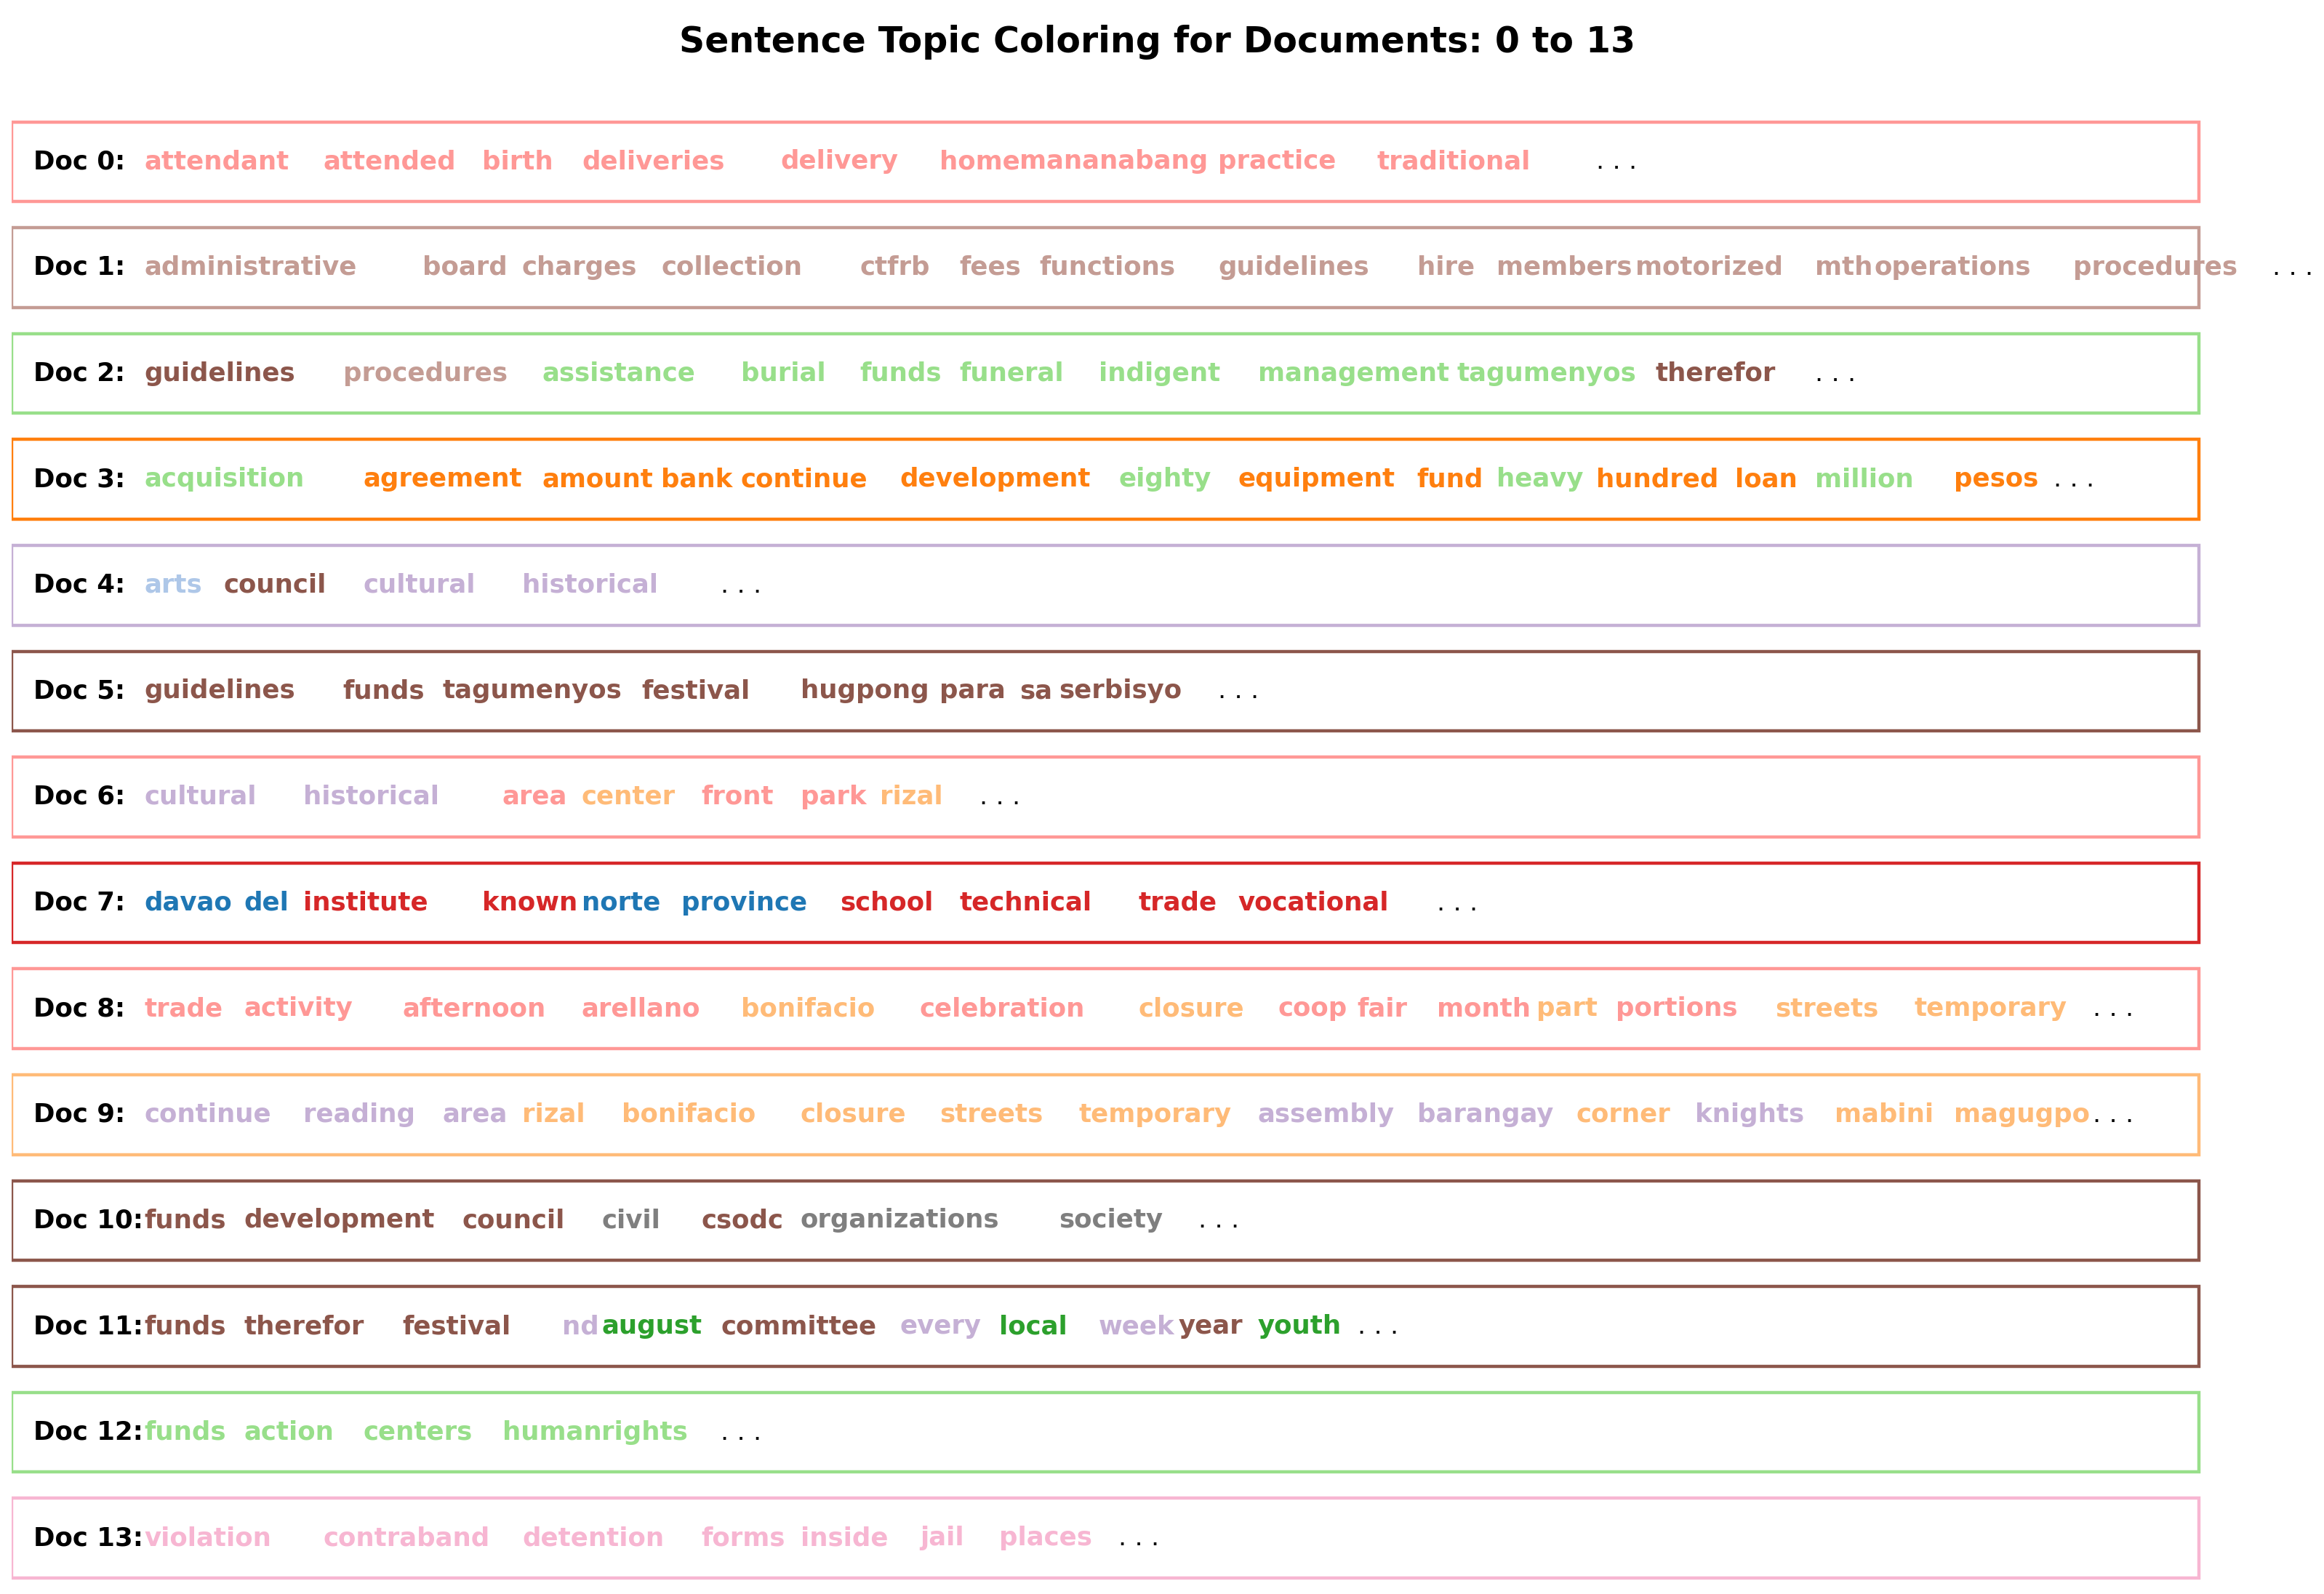

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

In [20]:

# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = tableau20

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()